# PrithviWxC

This notebook will walk you through how to construct the model, load the weights, build the dataset, and use the model for inference.

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import sys
sys.path.append("/u/dchevita/projects/Prithvi-WxC")

We now configure the backends and torch states, including setting the seeds for the RNGs.

In [3]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

The model has approximately 2.3 billion parameters, so it requires reasonable computational resources, but it is possible to run it on a CPU.

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataloader
### Variables and times

With the environment ready to go, we now need to set up the task. The core model
expects a fixed set of variables from the MERRA-2 dataset, which are prescribed
below. The variables are comprised of surface variables, surface static
variables, and variables at various vertical levels within the atmosphere. More
details on the MERRA-2 dataset can be found
[here](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/). 

The MERRA-2 dataset includes data at longitudes of $-180^\circ$ and $+180^\circ$.
This represents duplicate data, so we set a padding variable to remove it.

The input to the core model consists of these variables at two different times.
The time difference in hours between these samples is passed to the model and set in the input_time variable.

The model's task is to predict the fixed set of variables at a target time, given the input data.

For example, if the input times are 0900 and 1200, resulting in an input_time of -3, then a lead_time of 6 would result in a target time of 1800.

In [5]:
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

lead_times = [6]  # This varibale can be change to change the task
input_times = [-6]  # This varibale can be change to change the task

### Data file
MERRA-2 data is available from 1980 to the present day, at 3-hour temporal resolution. The dataloader we have provided expects the surface data and vertical data to be saved in separate files, and when provided with the directories, will search for the relevant data that falls within the provided time range.


In [6]:
time_range = ("2016-02-01T00:00:00", "2016-02-06T23:59:59")

surf_dir = Path("path/to/merra-2")
vert_dir = Path("path/to/merra-2")

### Climatology
The PrithviWxC model was trained to calculate the output by producing a perturbation to the climatology at the target time.
 This mode of operation is set via the `residual=climate` option. This was chosen as climatology is typically a strong prior for long-range prediction. When using the `residual=climate` option, we have to provide the dataloader with the path of the climatology data.

In [7]:
surf_clim_dir = Path("path/to/climatology")
vert_clim_dir = Path("path/to/climatology")

### Postion encoding
Position data is included in the data passed to the model,  as this allows the attention mechanism to determine data locality rather than explicit or implicit data connections. The position data is encoded in the model with two possible options, fourier or absolute. As these encoding options require different treatment within the data loader, the chosen option is set here.

In [8]:
positional_encoding = "fourier"

### Dataset init
We can now instantiate the MERRA2 Dataset class provided.

In [9]:
from PrithviWxC.dataloaders.merra2 import Merra2Dataset

dataset = Merra2Dataset(
    time_range=time_range,
    lead_times=lead_times,
    input_times=input_times,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

## The model
We are now ready to build the mdoel.
### Scalers
Additionally, the model takes as static parameters the mean and variance values of the input variables and the variance values of the target difference, i.e., the variance between climatology and instantaneous variables. We have provided data files containing these values, and here we load this data.

In [10]:
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)

surf_in_scal_path = Path("path/to/musigma_surface.nc")
vert_in_scal_path = Path("path/to/musigma_vertical.nc")
surf_out_scal_path = Path("path/to/anomaly_variance_surface.nc")
vert_out_scal_path = Path("path/to/anomaly_variance_vertical.nc")

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

### Task and additional configs
As previously mentioned, the PrithviWxC model's pretext task involved predicting the desired variable at a specific lead time. This was achieved by calculating the difference (delta) compared to the climatological average at that time. This operational mode is activated using the residual flag. Although the model includes additional residual options, the core model weights were not trained using these modes.

Additionally, for training and evaluation, it is possible to mask tokens in the model. The masking occurs after tokenization, prior to the encoder layers. The model utilizes multi-axis attention, with data broken down into a hierarchy of local and global patches. Consequently, masking can be configured to mask either small local patches or larger global patches. This configuration is achieved via the `masking_mode` flag. It is possible to set `masking_mode=both`. This does not mix the modes but rather allows both modes to be used and swapped between, primarily for training purposes. For this demonstration, we will adjust the masking ratio to showcase the reconstruction capabilities of the model.

Finally, we can set up shifting. Primarily utilized in the decoder, this enables alternate shifting of the attention windows, similar to the SWIN model. This option necessitates an even number of decoder blocks and is incompatible with the encoder when masking is also employed.

In [11]:
residual = "climate"
masking_mode = "local"
decoder_shifting = True
masking_ratio = 0.99

### Model init
We now have all the pieces to build the model. If you are using the pretrained weights, a number of the model hyperparameters are predetermined and included below. With this configuration, the model will have approximately 2.3 billion parameters. Therefore, if you want to train the fully unfrozen model, you will likely need to use a model distribution approach, such as fully shared data parallelism (FSDP). To further reduce the memory usage of the model when gradients are required, there are two variables — `checkpoint_encoder` and `checkpoint_decoder` — which enable activation checkpointing of desired transformer layers.

In [12]:
from PrithviWxC.model import PrithviWxC

model = PrithviWxC(
    in_channels=160,
    input_size_time=2,
    in_channels_static=8,
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=0.0,
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=0.0,
    output_scalers=output_sig**0.5,
    n_lats_px=360,
    n_lons_px=576,
    patch_size_px=[2, 2],
    mask_unit_size_px=[30, 32],
    mask_ratio_inputs=masking_ratio,
    embed_dim=2560,
    n_blocks_encoder=12,
    n_blocks_decoder=2,
    mlp_multiplier=4,
    n_heads=16,
    dropout=0.0,
    drop_path=0.0,
    parameter_dropout=0.0,
    residual=residual,
    masking_mode=masking_mode,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)

### Load weights
We have provided unshared pretrained weights for the model, which can now be loaded. The model can then be transferred to the requested device.

In [13]:
weights_path = Path("path/to/step_400.pt")

state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Inference
We are now ready to perform inference on the model. The data returned from the dataset class requires additional preprocessing; therefore, after polling the dataset, we process the data using the `preproc` function. This processed data is then transferred to the device. To recover the masking, we can save the torch RNG state and use it later. Finally, we run the model in evaluation mode without generating the gradient graph.

In [14]:
from PrithviWxC.dataloaders.merra2 import preproc

data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = model(batch)

## Plotting

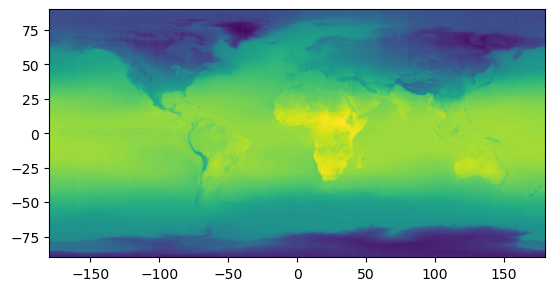

In [15]:
t2m = out[0, 12].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

plt.contourf(X, Y, t2m, 100)
plt.gca().set_aspect("equal")
plt.show()